# Simple linear regression analysis

*2023-09-24*

## Summary

The aim of this deck was to show how to perform a simple linear regression analysis on some data.
Data on the height, diameter, and side of the road (*east* or *west*) of 42 manna ash trees were collected and analysed.
An exploratory data analysis of the data was carried out, and a simple linear regression analysis was performed.

## Main

Import the dependencies.

In [1]:
import pandas as pd
from scipy import stats as st
import statsmodels.api as sm
import seaborn as sns
from matplotlib import pyplot as plt

Set the graphing defaults.

In [2]:
sns.set_theme()

Load the data.

In [3]:
manna_ash = pd.read_parquet("../Data/manna_ash.parquet")

Describe the `DataFrame`.

In [4]:
manna_ash.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tree_id   42 non-null     int64  
 1   diameter  42 non-null     float64
 2   height    42 non-null     int64  
 3   side      42 non-null     object 
dtypes: float64(1), int64(2), object(1)
memory usage: 1.4+ KB


Preview the `DataFrame`.

In [5]:
manna_ash.head()

,tree_id,diameter,height,side
0,271,0.23,9,west
1,270,0.21,8,west
2,269,0.20,7,west
3,268,0.21,8,west
4,272,0.21,9,west


### Exploratory data analysis

#### Univariate analysis

Summarise the `height` and `diameter` of trees.

In [28]:
manna_ash[["diameter", "height"]].describe().T

,count,mean,std,min,25%,50%,75%,max
diameter,42.0,0.242381,0.050789,0.15,0.2,0.24,0.2775,0.35
height,42.0,8.023810,1.717742,4.00,7.0,8.00,9.0000,10.00


Plot a bar chart of the number of trees observed by `side`.

**Result:**
The bar chart shows that there are approximately three times as many trees observed on the west side of the road compared to the east side of the road.

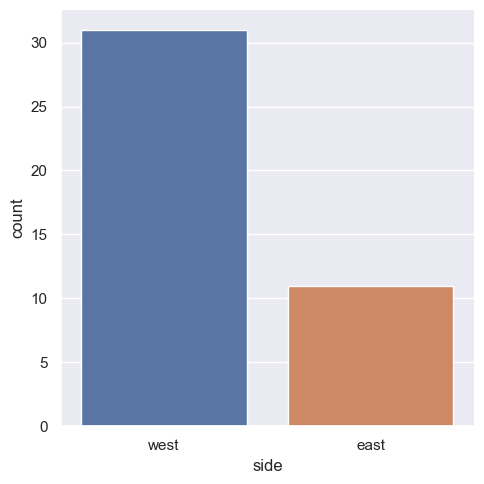

In [6]:
manna_ash[["side"]].value_counts().reset_index().pipe(
    sns.catplot, x="side", y="count", kind="bar"
)

Plot a histogram of `height`.

**Result:**
The data are left skew and unimodal with a peak at the 9-10 bin.

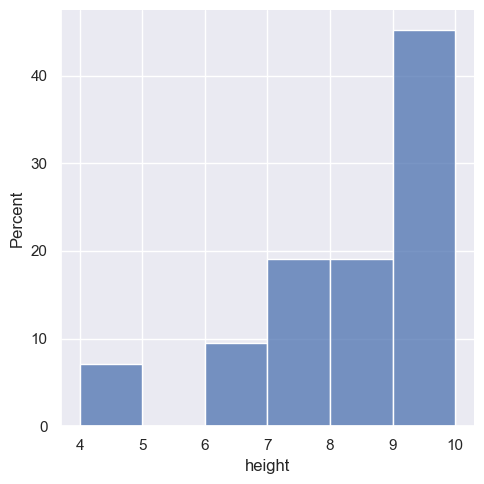

In [7]:
manna_ash.pipe(sns.displot, x="height", stat="percent", binwidth=1)

#### Bivariate analysis

Plot a histogram of `height` stratified by `side`.

**Result:**
The plot suggests that the distribution of tree heights on the west side is not the same as the height of trees of the east side.
Trees on the west side appear to have a similar distribution to the overall tree heights, whilst trees on the east side show a more symmetric distrbution with a small peak at the 7-8m bin.

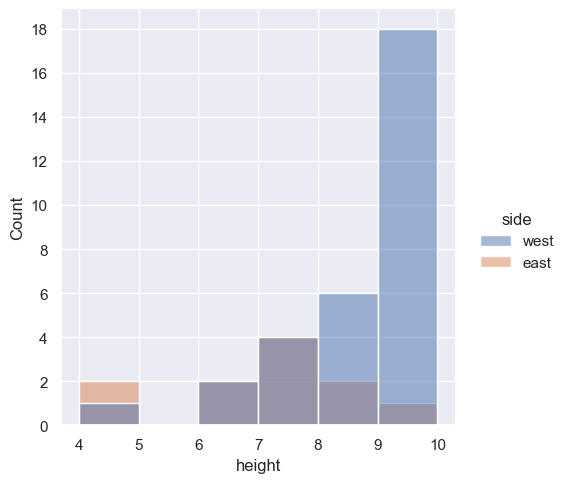

In [24]:
manna_ash.pipe(sns.displot, x="height", hue="side", binwidth=1)
plt.yticks(range(0, 20, 2))
plt.show()

Plot comparative boxplot of `height` stratified by `side`.

**Result:**
The trees on the west side are generally taller than the trees on the east side.
In addition, the distribution of `height` for trees on the west side seems to have a different shape to the distribution of `height` for trees on the east side.

The distribution of west side trees seem to be left skew, since there is no a high whisker but there is a low whisker.
There is also a potential outlier.

This is compared to trees on the east side, whose distribution looks approximately symmetric:
Its whiskers are roughly the same length, but the box is not particularly symmetric about the median.

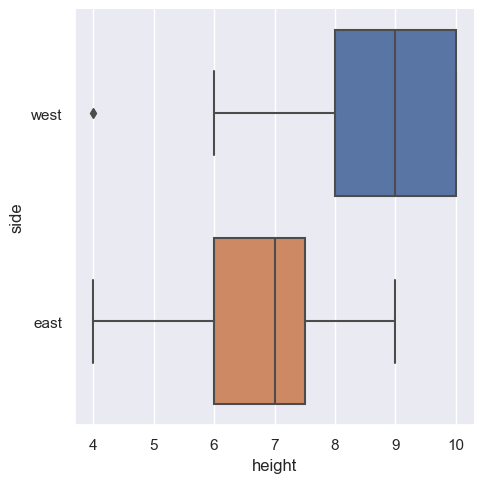

In [9]:
manna_ash.pipe(sns.catplot, x="height", y="side", kind="box")

Plot a scatterplot of `diameter` against `side`.

**Result:**
Taken as a whole, there seems to be a weak positive linear relationship between `diameter` and `height`, with no noticeable outliers.
However, if we also consider the groups, then the scatterplot shows two distinct clouds - one for the trees on the west side of the road, and the other for the trees on the east side.
The relationship between `diameter` and `height` appears to be stronger when considering each `side` separately, with less scatter.
This indicates that `side` may be a confounding variable in the relationship between `diameter` and `height`.

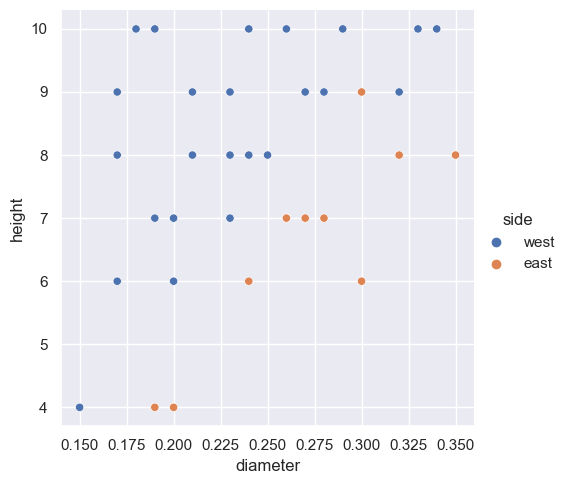

In [20]:
manna_ash.pipe(sns.relplot, x="diameter", y="height", hue="side")

Report the correlation of `height` and `diameter`.

**Result:**
The correlation is positive, but quite close to 0, suggesting there is a only a weak relationship between the two `height` and `diameter`.

In [12]:
st.pearsonr(manna_ash["height"], manna_ash["diameter"])

PearsonRResult(statistic=0.3627710547494399, pvalue=0.018219010713435492)

There is evidence that the height of trees may be confounded by the side of the road the trees are placed.

Test the hypotheses,

$$
H_{0}: m_{W} = m_{E};
\enspace H_{1}: m_{W} \ne m_{E}
$$

where $m_{W}, m_{E}$ are the median heights of trees on the west and east side of the road, respectively.

**Result:**
The test statistic is $u =$ 279, with a $p$-value $\simeq$ 0.0016.
Given $p <$ 0.01, there is strong evidence that the median heights of trees on the west and east side of the road are not the same.

In [13]:
st.mannwhitneyu(
    manna_ash.query("side == 'west'")["height"],
    manna_ash.query("side == 'east'")["height"]
)

MannwhitneyuResult(statistic=279.0, pvalue=0.0016339591033292895)

### Model the data

#### Fit the model

Model `height ~ diameter` and fit the data.

In [14]:
model = sm.OLS.from_formula("height ~ diameter", manna_ash)
result = model.fit()

Summarise the fitted model.

**Result:**

- The fitted model is `height = 5.05 + 12.27 diameter`
- The $p$-value for $\beta$ is reported as 0.018, which is moderate against the null hypothesis that $\beta =$ 0

In [15]:
print(result.summary(slim=True))

                            OLS Regression Results                            
Dep. Variable:                 height   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.110
No. Observations:                  42   F-statistic:                     6.062
Covariance Type:            nonrobust   Prob (F-statistic):             0.0182
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.0500      1.233      4.094      0.000       2.557       7.543
diameter      12.2692      4.983      2.462      0.018       2.198      22.341

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.


#### Check the model assumptions

Summarise the residual values.

**Result:**
The median is slightly greater than zero and the absolute value of the minimum value is greater than the maximum value.
However, the magnitude of the lower and upper quartiles are similar, which suggests symmetry.
Overall, we conclude that the residuals seem to be approximately symmetric about zero.

In [16]:
result.resid.describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
0,42.0,-6.978545e-16,1.600727,-3.503827,-1.213924,0.198672,1.128095,2.741558


Plot a histogram of the residuals.

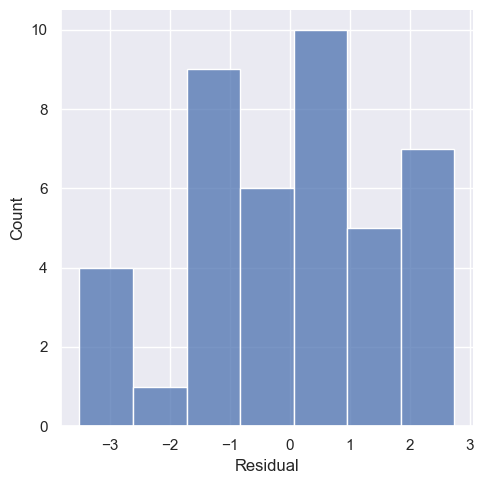

In [35]:
result.resid.rename("Residual").to_frame().pipe(sns.displot, x="Residual")

Plot a residual plot of residual against fitted value and normal probability plot of the residuals.

**Result:**
The points in the residual plot appear to be randomly scattered about zero, suggesting that the assumption that they have zero mean is reasonable.
There may be a slight decrease in spread as fitted values increase in size, whcih could suggest that the assumption of constant variance may not be the case.
However, the sample size $n=$ 42 is not large, and so it is difficult to draw any strong conclusions from the residual plot.

The normal probability plot shows that most points lie roughly along the straight line. so the assumption of normality does seem plausible.

Overall, we conclude that the assumptions of linearity, zeromean and constant variance does appear to be reasoanble.

Text(0.5, 0, 'Fitted value')

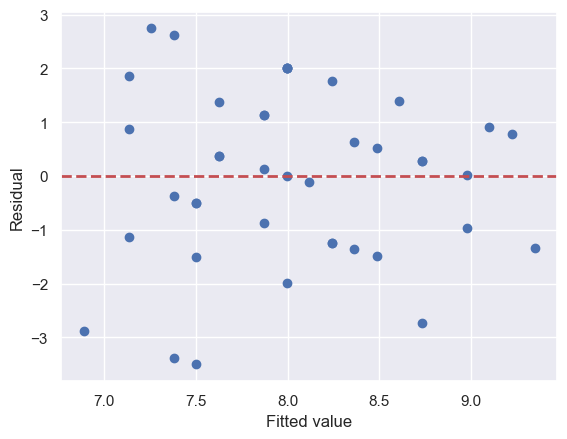

In [17]:
# Residual plot
plt.scatter(result.fittedvalues, result.resid)
plt.axhline(y=0, lw=2, ls="--", color="r")
plt.ylabel("Residual")
plt.xlabel("Fitted value")

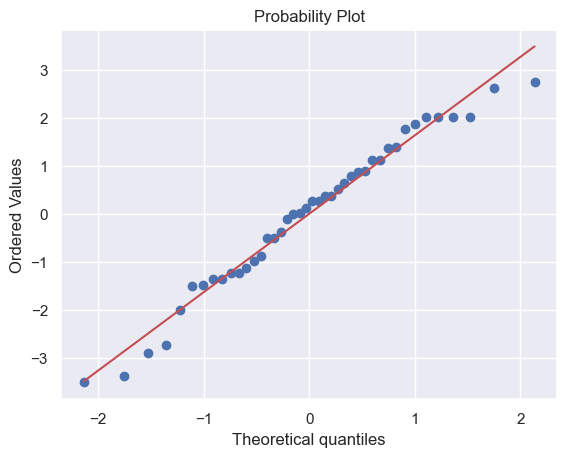

In [18]:
# Normal probability plot
_ = st.probplot(result.resid, plot=plt)

#### Use the model

Predict the height of a tree with a diameter of 0.25m.

**Result:**
The predicted height is 7.5m with 95% prediction interval (4.2, 10.8).

In [19]:
result.get_prediction(pd.DataFrame({"diameter": [0.2]})).summary_frame()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,7.503827,0.327317,6.842294,8.16536,4.16231,10.845345
